In [ ]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


In [ ]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display

In [ ]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 826,013 (3.15 MB)

 Trainable params: 275,336 (1.05 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 550,674 (2.10 MB)

None


In [ ]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:            #hakee tietyn kerroksen painot
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):                                 #käy läpi painot ja palauttaa niiden muodot
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):                              #jakaa mallin kolmeen osaan: alkuosa, tietty kerros, loppuosa
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



In [ ]:
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'                                      #datasetin haku, lataus ja purku

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [ ]:
#tähän tulee flatten&dense1(), arvosana 2

def flattenJaDense1(w2,b2):

    tulos = np.zeros((1,w2.shape[0]))

    tulos_flattened = tf.reshape(tulos, (1, -1))

    # Lisää Dense-kerros
    tulos = np.matmul(tulos_flattened, w2) + b2
    print("tulos shape = ", tulos.shape)

    return tulos #tämän shape pitää olla (1,128)

# Example usage
w2 = np.random.rand(3072, 128)  # Assuming w2 has shape (3072, 128)
b2 = np.random.rand(128)         # Bias should have shape (128,)

# Call the function
layer_oma_result = flattenJaDense1(w2, b2)
print("Layer output shape:", layer_oma_result.shape)


tulos shape =  (1, 128)
Layer output shape: (1, 128)


In [ ]:
# Tässä on Dense 2, arvosana 1

def dense2(a0,w1,b1):
  a1 = np.matmul(a0,w1) + b1
  #a1 = np.matmul(w1,a0) + b1
  return a1

def omaDense2(a0,w1,b1):
#Tässä kohtaa tarkistetaan, ovatko muuttujat TensorFlow-tensoreita, muunnetaan NumPy-taulukoiksi tarvittaessa
  if isinstance(a0, tf.Tensor):
     a0 = a0.numpy()
  if isinstance(w1, tf.Tensor):
      w1 = w1.numpy()
  if isinstance(b1, tf.Tensor):
      b1 = b1.numpy()

  tulos = np.zeros(b1.shape)  #Luodaan nollavektori, jonka pituus on 8, eli biasin koko
  print("b1 shape =", b1.shape)
  print("a0 shape =", a0.shape)

  for n in range(b1.shape[0]): #Ulompi silmukka käy läpi jokaisen tulosvektorin elementin
    for w in range(a0.shape[1]): #Sisempi silmukka käy läpi kaikki sisääntulon painot ja suorittaa summaoperaation
      tulos[n] += a0[0, w] * w1[w, n]  #kerrotaan sisääntulo ja painot
    tulos[n] += b1[n] #lisätään bias tulosvektorin n:nelle elementille

    print("tuloksen shape = ", tulos.shape)
  return tulos #palautetaan lopullinen tulos, joka on vektori


a0 = tf.random.uniform((1, 128)) #luodaan satunnaisia tensorflow-arvoja testausta varten
w1 = tf.random.uniform((128, 8))
b1 = tf.random.uniform((8,))


print("a0 shape:", a0.shape)  # (1, 128)
print("w1 shape:", w1.shape)  # (128, 8)
print("b1 shape:", b1.shape)  # (8,)


print("omaDense2 tulos:", omaDense2(a0, w1, b1))
print("dense2 tulos:", dense2(a0.numpy(), w1.numpy(), b1.numpy()))

a0 shape: (1, 128)
w1 shape: (128, 8)
b1 shape: (8,)
b1 shape = (8,)
a0 shape = (1, 128)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
omaDense2 tulos: [28.75367655 32.89268174 29.06856217 29.78238545 32.44527725 33.90967646
 29.82759266 29.85583599]
dense2 tulos: [[28.753675 32.89268  29.068562 29.782387 32.44528  33.90968  29.827593
  29.855837]]


In [ ]:
#def spectrogram():
#def resizing():
#def normalization():
#def convolution_1():
#def convolution_2():
#def maxPooling():
#def flattenJaDense1():
#def dense2(): tämä on tehty

In [ ]:
'''#tämä on esimerkkiohjelma
def get_spectrogram(waveform):                                                  #muuntaa aaltomuodon (waveform) spektrogrammiksi
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram
'''

'#tämä on esimerkkiohjelma\ndef get_spectrogram(waveform):                                                  #muuntaa aaltomuodon (waveform) spektrogrammiksi\n  # Convert the waveform to a spectrogram via a STFT.\n  spectrogram = tf.signal.stft(\n      waveform, frame_length=255, frame_step=128)\n  # Obtain the magnitude of the STFT.\n  spectrogram = tf.abs(spectrogram)\n  # Add a `channels` dimension, so that the spectrogram can be used\n  # as image-like input data with convolution layers (which expect\n  # shape (`batch_size`, `height`, `width`, `channels`).\n  spectrogram = spectrogram[..., tf.newaxis]\n  return spectrogram\n'

oma_get_spectrogram shape = (124, 129)


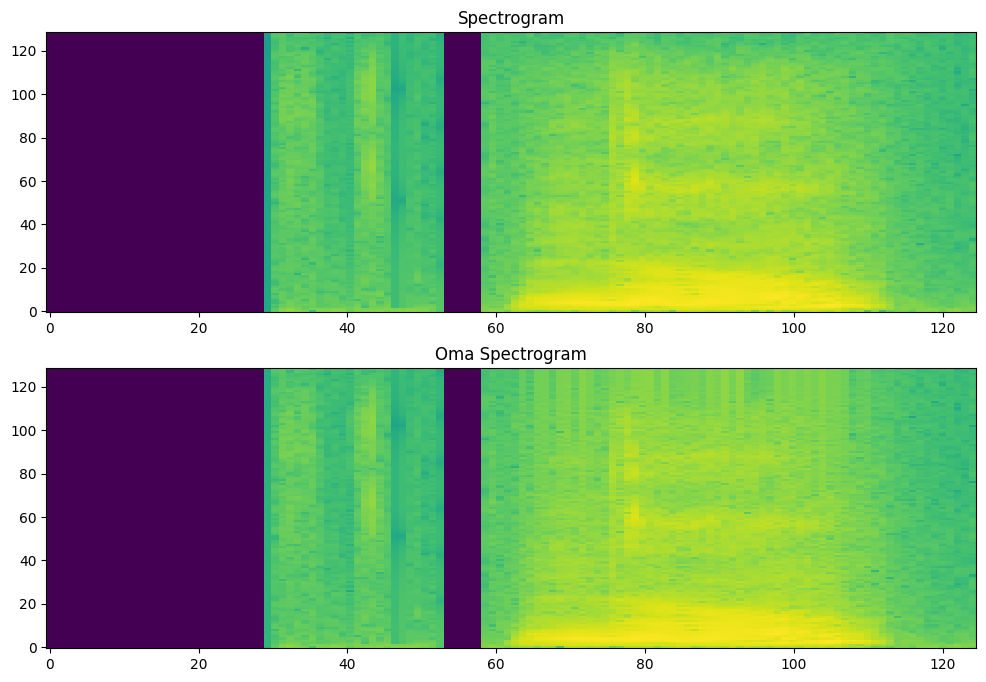

In [ ]:
def get_spectrogram(waveform):                                                  #muuntaa aaltomuodon (waveform) spektrogrammiksi
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

#tässä on oma get_spectrogram (joka on käytännössä sama kuin malli)

def oma_get_spectrogram(waveform):

    oma_spectrogram = np.zeros((124,129))

    for m in range(124):
        pala = waveform[128*m : 128*(m+1)+128]

        # Luo Hamming-ikkunafunktio, joka on saman pituinen kuin pala
        window = np.hamming(len(pala))

        # Kerrotaan pala ikkunafunktiolla
        ikkunallinen_pala = pala * window

        fft_result = np.fft.fft(ikkunallinen_pala)  # n=256 pituus
        #print("fft result shape", fft_result.shape)
        oma_spectrogram[m, :] = np.abs(fft_result[0:129])  # Ota vain ensimmäiset 129 arvoa

    # Tulostetaan spektrikuvan muoto ja joitain tilastoja
    print("oma_get_spectrogram shape =", oma_spectrogram.shape)

    return oma_spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, width, num=width)  # Aikajakso x-akselilla
  Y = np.arange(height)
  ax.pcolormesh(X, Y, log_spec, shading='auto')

def oma_plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, width, num=width)  # Aikajakso x-akselilla
  Y = np.arange(height)
  ax.pcolormesh(X, Y, log_spec, shading='auto')

# Load the sample audio file (no/01bb6a2a_nohash_0.wav)
#data_dir = pathlib.Path("path_to_your_audio_files")
audio_path = data_dir / 'no/01bb6a2a_nohash_0.wav'

# Read the audio file using TensorFlow
audio_binary = tf.io.read_file(str(audio_path))
waveform, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)

# Remove the unnecessary channel dimension
waveform = tf.squeeze(waveform, axis=-1)

# Compute the spectrograms using both methods
spectrogram = get_spectrogram(waveform)
oma_spectrogram = oma_get_spectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))

plot_spectrogram(spectrogram.numpy(), axes[0])
axes[0].set_title('Spectrogram')

plot_spectrogram(oma_spectrogram, axes[1])
axes[1].set_title('Oma Spectrogram')
plt.show()

x shape (1, 124, 129, 1)
oma_get_spectrogram shape = (124, 129)
resizing input shape = (1, 124, 129, 1)
resizing output shape = (1, 32, 32, 1)
get layer weights [array([0.12540941], dtype=float32), array([0.5840317], dtype=float32), 0]
normalization input shape = (1, 32, 32, 1)
convolution1 input shape = (1, 32, 32, 1)
convolution1 output shape = (1, 30, 30, 32)
maxPooling input shape = (1, 30, 30, 32)
maxPooling output shape = (1, 15, 15, 32)
convolution_2 input shape = (1, 15, 15, 32)
convolution_2 output shape = (1, 13, 13, 64)
maxPooling input shape = (1, 13, 13, 64)
maxPooling output shape = (1, 6, 6, 64)
convolution_2 input shape = (1, 6, 6, 64)
convolution_2 output shape = (1, 4, 4, 128)
convolution_2 input shape = (1, 4, 4, 128)
convolution_2 output shape = (1, 2, 2, 128)
maxPooling input shape = (2, 2, 128)
maxPooling tulos shape = (1, 1, 128)
input shape = (128,)
w2 shape =  (128, 256)
b2 shape =  (256,)
shape nollassa =  128
tulos shape =  (256,)
b1 shape = (8,)
a0 shape = (

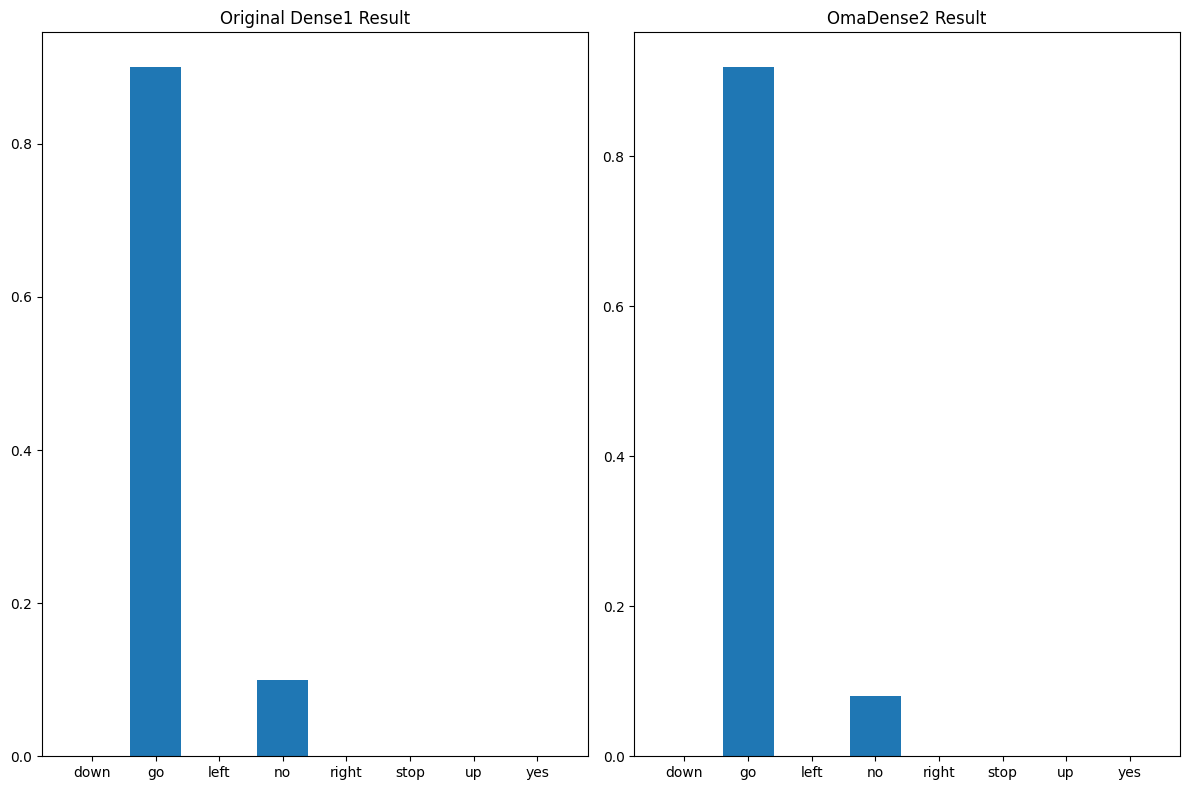

In [ ]:
def resizing(input, target_size=(32, 32)):
    # Muutetaan input-kuvan kokoa 32x32 kokoiseksi
    resized_input = tf.image.resize(input, target_size)
    resized_input = resized_input.numpy()  # Muunnetaan NumPy-taulukoksi jatkokäsittelyä varten
    print("resizing input shape =", input.shape)
    print("resizing output shape =", resized_input.shape)
    return resized_input

def normalization(input):

    print("get layer weights", get_layer_weights('normalization',model))
    m,v,a = get_layer_weights("normalization",model)
    print("normalization input shape =", input.shape)

    return (input - m) / np.sqrt(v)

def convolution1(input, name):
    # Haetaan suodatin ja bias
    w1, b1 = get_layer_weights(name, model)  # Haetaan painot ja bias kerrokselle

    print("convolution1 input shape =", input.shape)

    # Oletetaan, että suodatin on muotoa (3, 3, 1, num_filters)
    kernel_height, kernel_width, input_channels, num_filters = w1.shape

    # Määritellään tulosmatriisi
    output_height = input.shape[1] - kernel_height + 1  # Tuloksen korkeus
    output_width = input.shape[2] - kernel_width + 1    # Tuloksen leveys
    conv1_output = np.zeros((1, output_height, output_width, num_filters))  # Muoto: (1, h, w, n)

    # Suoritetaan konvoluutio
    for f in range(num_filters):  # Käsitellään jokainen suodatin
        for h in range(output_height):
            for w in range(output_width):
                # Otetaan 3x3 alue syötteestä
                region = input[0, h:h + kernel_height, w:w + kernel_width, 0]  # Input on muotoa (1, 32, 32, 1)
                # Lasketaan konvoluutio: alue * suodatin + bias
                conv1_output[0, h, w, f] = np.sum(region * w1[:, :, 0, f]) + b1[f]

                # ReLU-aktivaatio
                conv1_output[0, h, w, f] = max(0, conv1_output[0, h, w, f])

    print("convolution1 output shape =", conv1_output.shape)
    return conv1_output


def maxPooling(input, pool_size=(2,2)):

  batch_size, input_height, input_width, input_channels = input.shape
  pool_height, pool_width = pool_size

  output_height = input_height // pool_height # Lasketaan tulosmatriisin dimensio (olettaen ettei reunapikseleitä paddingillä käsitellä)
  output_width = input_width // pool_width

  output = np.zeros((batch_size, output_height, output_width, input_channels)) #luodaan tyhjä matriisi poolauksen tuloksille

  for b in range(batch_size):
    for c in range(input_channels):
      for i in range(output_height): #käydään syötematriisi läpi liukuvalla 2x2 ikkunalla
        for j in range(output_width):
            window = input[b, i*pool_height:(i+1)*pool_height, j*pool_width:(j+1)*pool_width, c]
            output[b, i, j, c] = np.max(window)

  print("maxPooling input shape =", input.shape)
  print("maxPooling output shape =", output.shape)

  return output

def convolution_2(input, name):

    # Haetaan suodatin ja bias
    w2, b2 = get_layer_weights(name, model)

    print("convolution_2 input shape =", input.shape)

    # Oletetaan, että suodatin on muotoa (3, 3, 128, 128) (korkeus, leveys, syvyys, suodattimien määrä)
    kernel_height, kernel_width, input_channels, num_filters = w2.shape

    # Määritellään tulosmatriisi
    output_height = input.shape[1] - kernel_height + 1  # Tämä on korkeus
    output_width = input.shape[2] - kernel_width + 1    # Tämä on leveys
    conv2_output = np.zeros((1, output_height, output_width, num_filters))  # Muoto: (1, h, w, n)

    # Suoritetaan konvoluutio
    for f in range(num_filters):
        for h in range(output_height):
            for w in range(output_width):
                # Suoritetaan konvoluutio
                region = input[0, h:h + kernel_height, w:w + kernel_width, :]
                conv2_output[0, h, w, f] = np.sum(region * w2[:, :, :, f]) + b2[f]
                if conv2_output[0, h, w, f] < 0:
                    conv2_output[0, h, w, f] = 0

    print("convolution_2 output shape =", conv2_output.shape)
    #print("Example conv2_output values:", conv2_output[0, :, :, :])
    return conv2_output

def maxPoolingSpecial(input):

  input = input.reshape(2,2,128)
  tulos= np.zeros((1,1,128)) #luodaan tyhjä matriisi poolauksen tuloksille

  for i in range(128):
    tulos[:,:,i] = np.max(input[:,:,i])


  print("maxPooling input shape =", input.shape)
  print("maxPooling tulos shape =", tulos.shape)

  return tulos

def flattenJaDense1(input):

    input = input.reshape(128)
    w2,b2 = get_layer_weights("dense",model)

    print("input shape =", input.shape)
    print("w2 shape = ", w2.shape)
    print("b2 shape = ", b2.shape)
    print("shape nollassa = ", w2.shape[0])

    tulos = np.zeros(256)

    # Lisää Dense-kerros
    tulos = np.matmul(input, w2) + b2
    for i in range(256):
      if tulos[i] < 0:
        tulos[i] = 0

    print("tulos shape = ", tulos.shape)

    return tulos

def omaDense2(a0,w1,b1):

  w1,b1 = get_layer_weights("dense_1",model)
  a0 = a0.reshape(1,-1)

  tulos = np.zeros(b1.shape)  #Luodaan nollavektori, jonka pituus on 8, eli biasin koko
  print("b1 shape =", b1.shape)
  print("a0 shape =", a0.shape)

  for n in range(b1.shape[0]): #Ulompi silmukka käy läpi jokaisen tulosvektorin elementin
    for w in range(a0.shape[1]): #Sisempi silmukka käy läpi kaikki sisääntulon painot ja suorittaa summaoperaation
      tulos[n] += a0[0, w] * w1[w, n]  #kerrotaan sisääntulo ja painot
    tulos[n] += b1[n] #lisätään bias tulosvektorin n:nelle elementille

    print("tuloksen shape = ", tulos.shape)
  return tulos #palautetaan lopullinen tulos, joka on vektori

#tässä haetaan tiedostosta x (voit muuttaa tiedoston nimeä)

x = data_dir/'go/0137b3f4_nohash_4.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
x = get_spectrogram(x)
x = x[tf.newaxis,...]
print("x shape", x.shape)

y = data_dir/'go/0137b3f4_nohash_4.wav'
y = tf.io.read_file(str(y))
y, sample_rate = tf.audio.decode_wav(y, desired_channels=1, desired_samples=16000,)
y = tf.squeeze(y, axis=-1)
y = oma_get_spectrogram(y)
y = y[tf.newaxis,...]

#testataan x-arvoa

(start, layer, end) = get_reference_layer("resizing", model)

input = start(y)

output = layer(input)

original_result = model(x)

resizing_result = resizing(input)

normalization_result = normalization(resizing_result)

convolution_result = convolution1(normalization_result, "conv2d")

maxPooling1_result = maxPooling(convolution_result)

convolution0_result = convolution_2(maxPooling1_result, "conv2d_1")

maxPooling2_result = maxPooling(convolution0_result)

convolution1_result = convolution_2(maxPooling2_result, "conv2d_2")

convolution2_result = convolution_2(convolution1_result, "conv2d_3")

maxPooling_result = maxPoolingSpecial(convolution2_result)

flattenJaDense1_result = flattenJaDense1(maxPooling_result)

omaDense2_result = omaDense2(flattenJaDense1_result,w1,b1)

omaDense2_result = omaDense2_result.reshape(1,-1)

print("omaDense2 result =", omaDense2_result)
print("original result =", original_result)

# Plotataan tulokset
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

plt.figure(1, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.bar(x_labels, tf.nn.softmax(tf.reshape(original_result[-1], [-1])[:8]))
plt.title('Original Dense1 Result')

plt.subplot(1, 2, 2)
plt.bar(x_labels, tf.nn.softmax(tf.reshape(omaDense2_result[-1], [-1])[:8]))
plt.title('OmaDense2 Result')

plt.tight_layout()
plt.show()


In [ ]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 826,013 (3.15 MB)

 Trainable params: 275,336 (1.05 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 550,674 (2.10 MB)

None


resizing input shape = (1, 124, 129, 1)
resizing output shape = (1, 32, 32, 1)
convolution1 input shape = (1, 32, 32, 1)
convolution1 output shape = (1, 30, 30, 32)
maxPooling input shape = (1, 30, 30, 32)
maxPooling output shape = (1, 15, 15, 32)
convolution_2 input shape = (1, 15, 15, 32)
convolution_2 output shape = (1, 13, 13, 64)
maxPooling input shape = (1, 13, 13, 64)
maxPooling output shape = (1, 6, 6, 64)
convolution_2 input shape = (1, 6, 6, 64)
convolution_2 output shape = (1, 4, 4, 128)
convolution_2 input shape = (1, 4, 4, 128)
convolution_2 output shape = (1, 2, 2, 128)
maxpoolingspecial input ennen reshape = (1, 2, 2, 128)
maxPooling input shape = (2, 2, 128)
maxPooling tulos shape = (1, 1, 128)
input shape = (128,)
w2 shape =  (128, 256)
b2 shape =  (256,)
shape nollassa =  128
tulos shape =  (256,)
b1 shape = (8,)
a0 shape = (1, 256)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)
tuloksen shape =  (8,)

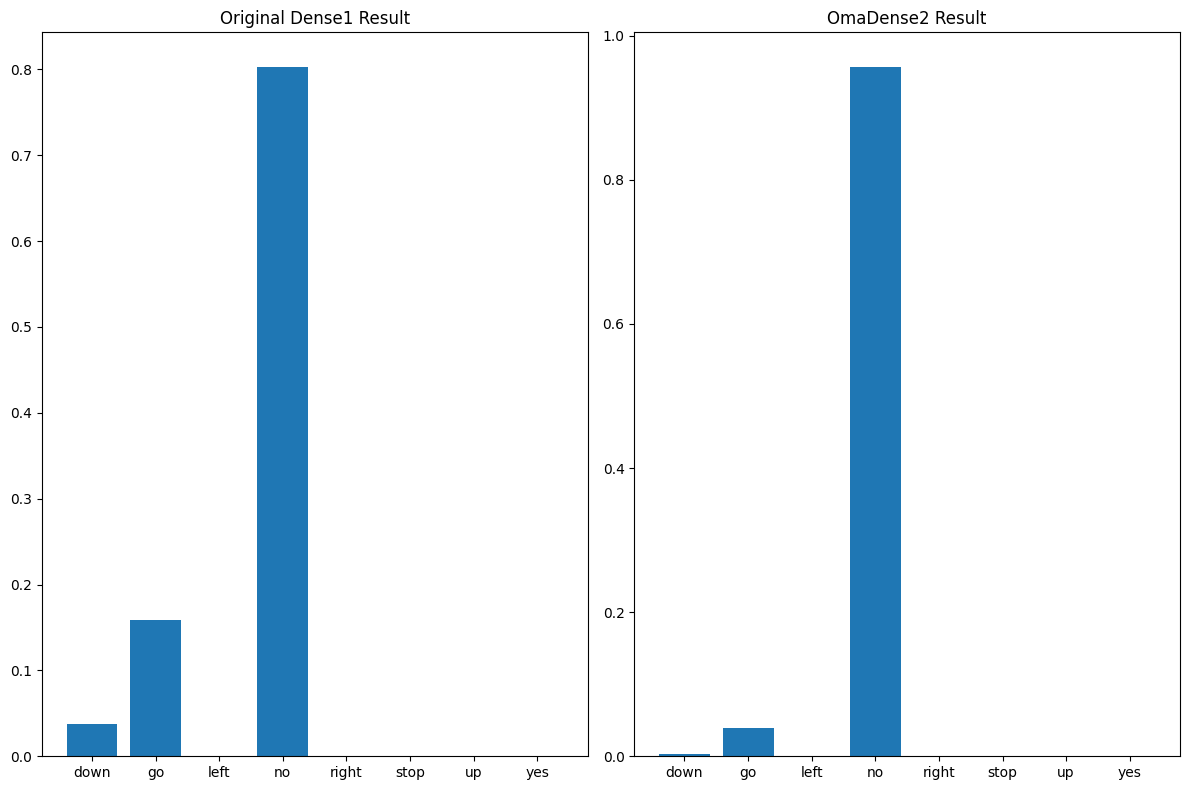

In [ ]:
#tässä on tallessa vain tämä jos kämmään:

def resizing(input, target_size=(32, 32)):
    # Muutetaan input-kuvan kokoa 32x32 kokoiseksi
    resized_input = tf.image.resize(input, target_size)
    resized_input = resized_input.numpy()  # Muunnetaan NumPy-taulukoksi jatkokäsittelyä varten
    print("resizing input shape =", input.shape)
    print("resizing output shape =", resized_input.shape)
    return resized_input

def normalization(input):
    # Normalisoidaan input, esimerkiksi käyttämällä batch normalization
    return (input - np.mean(input)) / np.std(input)

def convolution1(input, name):
    # Haetaan suodatin ja bias
    w1, b1 = get_layer_weights(name, model)  # Haetaan painot ja bias kerrokselle

    print("convolution1 input shape =", input.shape)

    # Oletetaan, että suodatin on muotoa (3, 3, 1, num_filters)
    kernel_height, kernel_width, input_channels, num_filters = w1.shape

    # Määritellään tulosmatriisi
    output_height = input.shape[1] - kernel_height + 1  # Tuloksen korkeus
    output_width = input.shape[2] - kernel_width + 1    # Tuloksen leveys
    conv1_output = np.zeros((1, output_height, output_width, num_filters))  # Muoto: (1, h, w, n)

    # Suoritetaan konvoluutio
    for f in range(num_filters):  # Käsitellään jokainen suodatin
        for h in range(output_height):
            for w in range(output_width):
                # Otetaan 3x3 alue syötteestä
                region = input[0, h:h + kernel_height, w:w + kernel_width, 0]  # Input on muotoa (1, 32, 32, 1)
                # Lasketaan konvoluutio: alue * suodatin + bias
                conv1_output[0, h, w, f] = np.sum(region * w1[:, :, 0, f]) + b1[f]

                # ReLU-aktivaatio
                conv1_output[0, h, w, f] = max(0, conv1_output[0, h, w, f])

    print("convolution1 output shape =", conv1_output.shape)
    return conv1_output


def maxPooling(input, pool_size=(2,2)):

  batch_size, input_height, input_width, input_channels = input.shape
  pool_height, pool_width = pool_size

  output_height = input_height // pool_height # Lasketaan tulosmatriisin dimensio (olettaen ettei reunapikseleitä paddingillä käsitellä)
  output_width = input_width // pool_width

  output = np.zeros((batch_size, output_height, output_width, input_channels)) #luodaan tyhjä matriisi poolauksen tuloksille

  for b in range(batch_size):
    for c in range(input_channels):
      for i in range(output_height): #käydään syötematriisi läpi liukuvalla 2x2 ikkunalla
        for j in range(output_width):
            window = input[b, i*pool_height:(i+1)*pool_height, j*pool_width:(j+1)*pool_width, c]
            output[b, i, j, c] = np.max(window)

  print("maxPooling input shape =", input.shape)
  print("maxPooling output shape =", output.shape)

  return output

def convolution_2(input, name):

    # Haetaan suodatin ja bias
    w2, b2 = get_layer_weights(name, model)  # Muista, että kerroksesi nimi voi olla eri

    print("convolution_2 input shape =", input.shape)

    # Oletetaan, että suodatin on muotoa (3, 3, 128, 128) (korkeus, leveys, syvyys, suodattimien määrä)
    kernel_height, kernel_width, input_channels, num_filters = w2.shape

    # Määritellään tulosmatriisi
    output_height = input.shape[1] - kernel_height + 1  # Tämä on korkeus
    output_width = input.shape[2] - kernel_width + 1    # Tämä on leveys
    conv2_output = np.zeros((1, output_height, output_width, num_filters))  # Muoto: (1, h, w, n)

    # Suoritetaan konvoluutio
    for f in range(num_filters):
        for h in range(output_height):
            for w in range(output_width):
                # Suoritetaan konvoluutio
                region = input[0, h:h + kernel_height, w:w + kernel_width, :]
                conv2_output[0, h, w, f] = np.sum(region * w2[:, :, :, f]) + b2[f]
                if conv2_output[0, h, w, f] < 0:
                    conv2_output[0, h, w, f] = 0



    print("convolution_2 output shape =", conv2_output.shape)
    #print("Example conv2_output values:", conv2_output[0, :, :, :])
    return conv2_output

def maxPoolingSpecial(input):

  print("maxpoolingspecial input ennen reshape =", input.shape)

  input = input.reshape(2,2,128)
  tulos= np.zeros((1,1,128)) #luodaan tyhjä matriisi poolauksen tuloksille

  for i in range(128):
    #print("input =", input[:,:,i])
    #print("kierros", i)
    tulos[:,:,i] = np.max(input[:,:,i])


  print("maxPooling input shape =", input.shape)
  print("maxPooling tulos shape =", tulos.shape)

  return tulos

def flattenJaDense1(input):

    input = input.reshape(128)
    w2,b2 = get_layer_weights("dense",model)

    print("input shape =", input.shape)
    print("w2 shape = ", w2.shape)
    print("b2 shape = ", b2.shape)
    print("shape nollassa = ", w2.shape[0])

    tulos = np.zeros(256)


    # Lisää Dense-kerros
    tulos = np.matmul(input, w2) + b2
    for i in range(256):
      if tulos[i] < 0:
        tulos[i] = 0

    print("tulos shape = ", tulos.shape)

    return tulos #tämän shape pitää olla (1,128)

def omaDense2(a0,w1,b1):

  w1,b1 = get_layer_weights("dense_1",model)
  a0 = a0.reshape(1,-1)

  tulos = np.zeros(b1.shape)  #Luodaan nollavektori, jonka pituus on 8, eli biasin koko
  print("b1 shape =", b1.shape)
  print("a0 shape =", a0.shape)

  for n in range(b1.shape[0]): #Ulompi silmukka käy läpi jokaisen tulosvektorin elementin
    for w in range(a0.shape[1]): #Sisempi silmukka käy läpi kaikki sisääntulon painot ja suorittaa summaoperaation
      tulos[n] += a0[0, w] * w1[w, n]  #kerrotaan sisääntulo ja painot
    tulos[n] += b1[n] #lisätään bias tulosvektorin n:nelle elementille

    print("tuloksen shape = ", tulos.shape)
  return tulos #palautetaan lopullinen tulos, joka on vektori


#tässä haetaan tiedostosta x (voit muuttaa tiedoston nimeä)

x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
x = get_spectrogram(x)
x = x[tf.newaxis,...]

#testataan x-arvoa

(start, layer, end) = get_reference_layer("resizing", model)

input = start(x)

output = layer(input)
original_result = end(output)

resizing_result = resizing(input)

normalization_result = normalization(resizing_result)

convolution_result = convolution1(normalization_result, "conv2d")

maxPooling1_result = maxPooling(convolution_result)

convolution0_result = convolution_2(maxPooling1_result, "conv2d_1")

maxPooling2_result = maxPooling(convolution0_result)

convolution1_result = convolution_2(maxPooling2_result, "conv2d_2")

convolution2_result = convolution_2(convolution1_result, "conv2d_3")

maxPooling_result = maxPoolingSpecial(convolution2_result)

flattenJaDense1_result = flattenJaDense1(maxPooling_result)

omaDense2_result = omaDense2(flattenJaDense1_result,w1,b1)

omaDense2_result = omaDense2_result.reshape(1,-1)

print("omaDense2 result =", omaDense2_result)
print("original result =", original_result)

# Plotataan tulokset
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

plt.figure(1, figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.bar(x_labels, tf.nn.softmax(tf.reshape(original_result[-1], [-1])[:8]))
plt.title('Original Dense1 Result')

plt.subplot(1, 2, 2)
plt.bar(x_labels, tf.nn.softmax(tf.reshape(omaDense2_result[-1], [-1])[:8]))
plt.title('OmaDense2 Result')

plt.tight_layout()
plt.show()


flattenJaDense1 input shape funktion sisällä = (1, 128)
w2 shape =  (128, 256)
b2 shape =  (256,)
flattenJaDense1 shape nollassa =  128
flattenJaDense1 tulos shape =  (256,)
flattenJaDense1 input shape = (1, 128)
dense output shape = (1, 256)
flattenJaDense1_result shape = (256,)
tulosten ero = 3.9711595e-06
b1 shape = (8,)
a0 shape = (1, 256)
omaDense2 tuloksen shape =  (8,)
omaDense2 tuloksen shape =  (8,)
omaDense2 tuloksen shape =  (8,)
omaDense2 tuloksen shape =  (8,)
omaDense2 tuloksen shape =  (8,)
omaDense2 tuloksen shape =  (8,)
omaDense2 tuloksen shape =  (8,)
omaDense2 tuloksen shape =  (8,)
dense2_result shape = (8,)
dense2_result shape = (1, 8)
tulosten ero = 1.3113022e-06


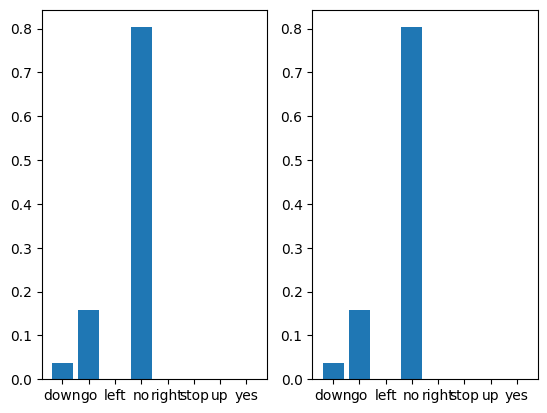

In [ ]:
#tämä on koekappale:

def omaDense2(a0,w1,b1):

  w1,b1 = get_layer_weights("dense_1",model)
  a0 = a0.reshape(1,-1)

  tulos = np.zeros(b1.shape)  #Luodaan nollavektori, jonka pituus on 8, eli biasin koko
  print("b1 shape =", b1.shape)
  print("a0 shape =", a0.shape)

  for n in range(b1.shape[0]): #Ulompi silmukka käy läpi jokaisen tulosvektorin elementin
    for w in range(a0.shape[1]): #Sisempi silmukka käy läpi kaikki sisääntulon painot ja suorittaa summaoperaation
      tulos[n] += a0[0, w] * w1[w, n]  #kerrotaan sisääntulo ja painot
    tulos[n] += b1[n] #lisätään bias tulosvektorin n:nelle elementille

    print("omaDense2 tuloksen shape = ", tulos.shape)
  return tulos #palautetaan lopullinen tulos, joka on vektori

def flattenJaDense1(input):

    print("flattenJaDense1 input shape funktion sisällä =", input.shape)
    input = input.numpy().reshape(128)
    w2,b2 = get_layer_weights("dense",model)


    print("w2 shape = ", w2.shape)
    print("b2 shape = ", b2.shape)
    print("flattenJaDense1 shape nollassa = ", w2.shape[0])

    tulos = np.zeros(256)


    # Lisää Dense-kerros
    tulos = np.matmul(input, w2) + b2
    for i in range(256):
      if tulos[i] < 0:
        tulos[i] = 0

    print("flattenJaDense1 tulos shape = ", tulos.shape)

    return tulos #tämän shape pitää olla (1,128)

#testataan x-arvoa layeriin flattenJaDense1
(start, layer, end) = get_reference_layer("dense", model)

input = start(x)

output = layer(input)

dense1_result = flattenJaDense1(input)

print("flattenJaDense1 input shape =", input.shape)
print("dense output shape =", output.shape)
print("flattenJaDense1_result shape =", dense1_result.shape)

print('tulosten ero =', np.sum(np.abs(output - dense1_result)))

#testataan x-arvoa layeriin omaDense2
(start, layer, end) = get_reference_layer("dense_1", model)

input = start(x)

output = layer(input)

dense2_result = omaDense2(dense1_result,w1,b1)
print('dense2_result shape =', dense2_result.shape)

dense2_result = dense2_result.reshape(1,-1)
print('dense2_result shape =', dense2_result.shape)


print('tulosten ero =', np.sum(np.abs(output[:, :8] - dense2_result)))


x_labels = ['down','go','left','no','right','stop','up','yes']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(tf.reshape(output[-1], [-1])[:8]))
plt.subplot(1,2,2)
plt.bar(x_labels, tf.nn.softmax(tf.reshape(dense2_result[-1], [-1])[:256]))
plt.show()